#K-Nearest Neighbours
We'll use the K-Nearest Neighbours algorithm to classify data from the hepatitis and breast cancer datasets as positive and negative cases. 

The model's hyperparameter K is tuned according to performance metrics over k-fold cross validation sets. 

In [ ]:
#importing dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import recall_score, precision_score, precision_recall_curve, f1_score
from google.colab import drive
drive.mount('/content/drive')

#Change your path if you need too
path_Theo = '/content/drive/My Drive/COMP 551/Assignments/Assignment 1/processed_data/'
path_David = ''
path_Jacob = '/content/drive/My Drive/Assignments/Assignment 1/processed_data/' 

path = path_Theo

Mounted at /content/drive


## 1 K-Nearest Neighbours Implementation

In [ ]:
#distance functions 
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1)) #distances
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:
    '''K-Nearest Neighbour class'''
    def __init__(self, K=1, dist_fn=euclidean):
        '''KNN constructor
        @param K : number of nearest neighbours
        @param dist_func : lambda function to compute distance to neighbours'''
        self.dist_fn = dist_fn #initializing distance
        self.K = K #initializing hyper paramter K
        return
    
    def fit(self, x, y):
        ''' Store the training data using this method as it is a lazy learner
        @param x : (trianing) dataset features
        @param y : (training) dataset labels'''
        self.x = x
        self.y = y
        self.C = np.max(y)+1
        return self

    def get_neighbours(self, x_test):
        '''Get the K nearest neighbours for each example in the test set,
        and the probability of the test label for each class
        @param x_test : np.array of test set
        @param knns : np.array of k nearerst neighhbours
        @param y_prob : np.array of probabilities for each class for each test example. 
        '''
        num_test = x_test.shape[0] #number of testing examplees

        #calculate distance between the training & test examples and returns an array of shape [num_test, num_train]
        #with each row being the distances of one example in the training set to all the examples in the test set
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])

        #initializinig matrices (each row of knn matrix are the KNN of an example in the test set)
        #y-prob is the prediction for a test example. Each example (row) has C probablities (columns)
        knns, y_prob = np.zeros((num_test, self.K), dtype=int), np.zeros((num_test, self.C)) 

#        neighbour_y = np.zeros((num_test, self.K), dtype=int)
        #iterate over the testing examples and build the KNN matrix by its K smallest distances to its neighbours. 
        for i in range(num_test):
          knns[i,:] = np.argsort(distances[i])[:self.K]
          classes_present = self.y[knns[i,:]].flatten()
          y_prob[i,:] = np.bincount(classes_present, minlength=self.C) #counts the number of instances of each class in the K-closest training samples
        return knns, y_prob

    def predict(self, x_test, skew_K = 5, skew_prob = 2):
        '''Get the nearest neighbours and the class probabilities and make a prediction for the test set's labels. 
        @param x_test : np.array of test set
        @param skew_K : number of neighbours threshold for changing probability threshold
        @param skew_prob : new probabilty thheshold 
        @return y_pred : np.array of predicted labels for test set
        @return knns : K Nearest neighbours of test set. 
        '''
        knns, y_prob = self.get_neighbours(x_test) #get the knn for the test set 
        y_prob /= np.sum(y_prob, axis=-1, keepdims=True) #compute the probabilities for each class
        y_pred = np.argmax(y_prob,axis=-1) #set the label as the class with the highest probability 

        # if self.K >= skew_K and y_pred[0] >= skew_prob: #if probability is greater than threshold 
        #    y_pred = np.argmin(y_prob,axis=-1) #take the class with the lower probability 
        return y_pred, knns

### 1.1 Performance Metrics

In [ ]:
def evaluate_acc(y_prediction, y_test):
  '''Evaluate accuracy, recall, precision, and f1 between prediction labels and actual labels'''
  acc = np.sum(y_prediction == y_test) / y_test.shape[0]
  rec = recall_score(y_test, y_prediction)
  prec = precision_score(y_test, y_prediction)
  f1 = f1_score(y_test, y_prediction)
  return acc, prec,rec,f1


def show_results(metrics, observe = None, K_range = 100):
  '''Display the evaluation metrics for a range of K values
  @param metrics: dictionary of evaluation metrics 
  @param observe: metric to observe. dictionary key for evaluation metrics. string. if None, show all results
  @param K_range: range of K values through which to calculate performance. 
  '''
  K_list = list(range(K_range)) #list of K values 
  plt.suptitle('Peformance Metrics on Validation and Test Sets',fontsize=20, x =0.4)
  if observe == None: #display all results 
    fig = plt.figure(figsize= (20,12))
    for i,metric in enumerate(metrics):
      fig.add_subplot(3,2,i+1)
      plt.plot(K_list, metrics[metric][1],  label=(f'{metric} on test set'))
      plt.errorbar(K_list, np.mean(metrics[metric][0], axis=1), np.std(metrics[metric][0], axis=1),
                   label=(f'{metric} on validation set'))
      plt.legend(), plt.xlabel('K (number of neighbours)'), plt.ylabel(metric)
    fig.tight_layout(rect=[0.03, 0.03, 0.8, 0.97])
    plt.show()
  else: #display specified result
    fig = plt.figure(figsize= (20,12))
    plt.plot(K_list, metrics[observe][1],  label=(f'{observe} on test set'))
    plt.errorbar(K_list, np.mean(metrics[observe][0], axis=1),
                  np.std(metrics[observe][0], axis=1), label=(f'{observe} on validation set'))
    plt.legend(), plt.xlabel('K (number of neighbours)'), plt.ylabel(observe)
    plt.show()

###1.3 Cross Validation
Let's split the dataset into a test set and a cross validation set, train and test the model L times over L folds of the cross validation set, and then test the model over the test set. 

In [ ]:
loss = lambda y, yh: np.mean((y-yh)**2) #mean squae error loss

def split_data(dataset, test_prop = 0.2):
  '''Takes a dataset and separates into a training (for cross validation) 
  and a test set. 
  @param dataset : dataset as np.array 
  @param test_prop : proportion of test data (default: 20% of data for testing)
  @return x_train, y_train, x_test, y_test : np.arrays for training and test set features and labels. 
  '''
  y,x = dataset[:,:1].astype(int), dataset[:,1:] #separate features and labels
  sample_count = x.shape[0]  #number of total examples
  test_count = int(sample_count * 0.2) #number of test examples 
  x_train, y_train = x[test_count:], y[test_count:] #slice training set
  x_test, y_test = x[:test_count], y[:test_count] #slice test set
  return x_train, y_train, x_test, y_test 

def get_cv_index(num_train, L = 5):
  '''Generates indices for slicing training set into L fold cross validation set. 
  @param num_train: length of cross validation set
  @param L : number of folds
  @yield validation_indices, train_indices: indices for validation set and for training within cross validation set
  '''
  indices = list(range(num_train))
  num_val = num_train // L
  for l in range(L):
    validation_indices = list(range(l * num_val, (l+1)*num_val))
    train_indices = [x for x in indices if x not in validation_indices]  
    yield validation_indices, train_indices

def cross_validate_and_test(dataset, K_range = 100, test_prop = 0.2, L = 5, distance = euclidean):
  '''Seperate the dataset into cross validation and test set. Train and test 
  through a range of K values and diplay the results
  @param dataset : np array dataset
  @param K_range : range of K through which to test
  @param test_prop : proportion of test data (default: 20% of data for testing)
  @param L : number of folds
  @return metrrics : dictionary of performance metrics'''
  K_list = list(range(K_range)) #range of K values 
  x, y, x_test, y_test = split_data(dataset, test_prop) #split dataset into train and test features and labels
  #initialize performance metrics 
  metrics = {'accuracy': [np.zeros((len(K_list), L)), np.zeros((len(K_list)))], 
             'recall': [np.zeros((len(K_list), L)), np.zeros((len(K_list)))],
             'precision': [np.zeros((len(K_list), L)), np.zeros((len(K_list)))],
             'f1': [np.zeros((len(K_list), L)), np.zeros((len(K_list)))], 
              'loss (MSE)': [np.zeros((len(K_list), L)), np.zeros((len(K_list)))]
             }
  #iterate through range of K values and validation sets         
  for i,_K in enumerate(K_list):
    for f, indices in enumerate(get_cv_index(x.shape[0], L)):
      (val_inds, train_inds) = indices
      x_train, x_val = x[train_inds], x[val_inds] #slice out train and validation sets
      y_train, y_val = y[train_inds], y[val_inds]
      model = KNN(K=_K, dist_fn = distance) #create a model
      y_val_pred,_ = model.fit(x_train, y_train).predict(x_val) #fit training data and predict on validation data
      #get evaluation metrics
      metrics['accuracy'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[0] 
      metrics['precision'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[1] 
      metrics['recall'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[2] 
      metrics['f1'][0][i, f] = evaluate_acc(y_val_pred, y_val.flatten())[3]
      metrics['loss (MSE)'][0][i,f] = loss(y_val_pred, y_val.flatten())  
    #predict on test_set and evaluate
    model = KNN(K=_K, dist_fn = distance) #create a model
    y_test_pred,_ = model.fit(x, y).predict(x_test) #fit training data and predict on validation data
    metrics['accuracy'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[0]  
    metrics['precision'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[1]  
    metrics['recall'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[2]  
    metrics['f1'][1][i] = evaluate_acc(y_test_pred, y_test.flatten())[3] 
    metrics['loss (MSE)'][1][i] = loss(y_test_pred, y_test.flatten()) 

  #best in validation set
  best_accuracy_v = np.mean(metrics['accuracy'][0], axis=1).max()
  best_K_v = np.array(K_list)[np.argmax(np.mean(metrics['accuracy'][0], axis=1))]
  print(f'\nHighest accuracy of {100*best_accuracy_v :.3f} on validation set is obtained for K = {best_K_v} ')
  #best in test set                             
  best_accuracy_t = metrics['accuracy'][1].max()
  best_K_t = np.array(K_list)[np.argmax(metrics['accuracy'][1])]
  print(f'\nHighest accuracy of {100*best_accuracy_t :.3f} on test set is obtained for K = {best_K_t} ')
  return metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t


In [ ]:
#dataframe to contain our test results
results = pd.DataFrame({'Dataset':[], 'Distance':[], 'Highest Accuracy (Val)':[],
           'Highest Accuracy (Test)':[], 'Best K (Val)':[], 'Best K (Test)':[]})

###1.4 Plot Decision Boundaries

In [ ]:
def display_decision_boundry(data, k_number ,xlabel,ylabel,name, distance = euclidean):
  num_classes=2
  x_train, y_train, x_test, y_test = split_data(data)
  x_allX=data[:,1:]
  x0v = np.linspace(np.min(x_allX[:,0]), np.max(x_allX[:,0]), 200)
  x1v = np.linspace(np.min(x_allX[:,1]), np.max(x_allX[:,1]), 200)
  x2v = np.linspace(np.min(x_allX[:,2]), np.max(x_allX[:,2]), 200)
  x0,x1 = np.meshgrid(x0v, x1v)
  x_all = np.vstack((x0.ravel(),x1.ravel())).T
  y_train_prob = np.zeros((y_train.shape[0], 3))
  y_train=np.ndarray.flatten(y_train)
  y_train_prob[np.arange(y_train.shape[0]), y_train] = 1

  model = KNN(K=k_number, dist_fn = distance)
  feature_space = model.fit(x_train[:,:2], y_train)
  y_prediction,knns = feature_space.predict(x_all)
  y_prob_all=y_prediction
  y_prob_all= [[1,0,0] if x==0 else [0,1,0] for x in y_prob_all] #make the output classification into the appropriate colour

  plt.scatter(x_train[:,0], x_train[:,1], c=y_train_prob, marker='o', alpha=1, label = 'positive')
  plt.scatter(x_all[:,0], x_all[:,1], c=y_prob_all, marker='^', alpha=.01, label = 'negative') 
  plt.ylabel(ylabel), plt.xlabel(xlabel), plt.title('Red: Positive, Green: Negative')
  plt.show()

## 2 Binary Classification on Breast Cancer Dataset using KNN
Let's test the algorithm on the breast cancer dataset first. We'll partition the dataset into a test set (20% of data) and a 5-fold cross validation set (80% of data). 

As KNN is a lazy learner, the cross validation set will be used to tune the hyperparameter K to minimize the generalization error. This error will be estimated using the mean squared error. 
We'll validate and test through K = 1 to K = 20. 

### 2.1 Scaled Breast Cancer Dataset with Euclidean Distance



In [ ]:
cancer_scaled = pd.read_csv(path+'cancer_scaled.csv', index_col=0)
cancer_scaled = cancer_scaled.to_numpy().astype(float)
np.random.shuffle(cancer_scaled)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 97.064 on validation set is obtained for K = 5 

Highest accuracy of 97.059 on test set is obtained for K = 5 


<Figure size 432x288 with 0 Axes>

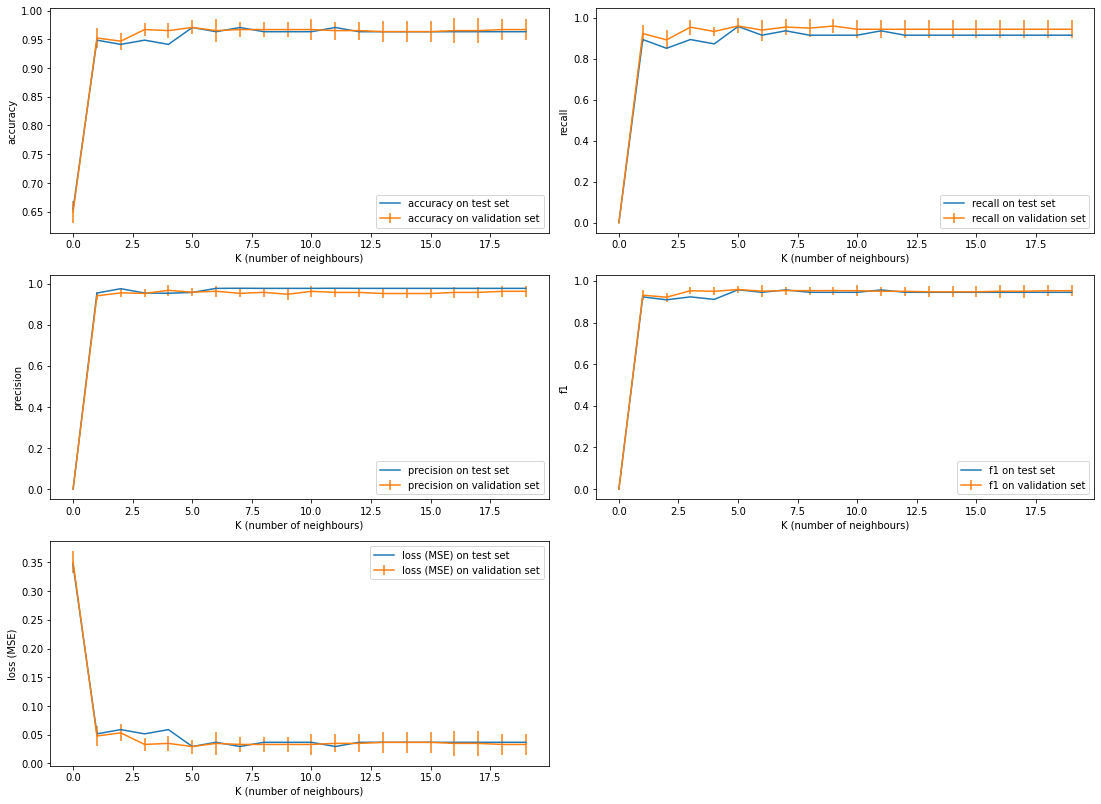

In [ ]:
metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(cancer_scaled, K_range=20)
show_results(metrics, K_range=20)

results = results.append(pd.DataFrame({'Dataset':['cancer scaled'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

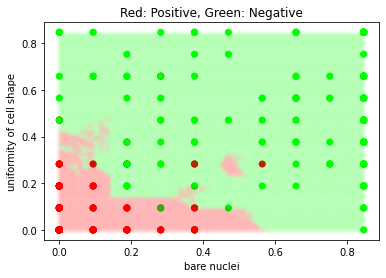

In [ ]:
display_decision_boundry(cancer_scaled, 5, "bare nuclei","uniformity of cell shape","Decision boundry for cancer")

### 2.2 Non Scaled Breast Cancer Dataset with Euclidean Distance



In [ ]:
cancer_unscaled = pd.read_csv(path+'cancer_unscaled.csv', index_col=0)
cancer_unscaled = cancer_unscaled.to_numpy().astype(float)
np.random.shuffle(cancer_unscaled)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 96.881 on validation set is obtained for K = 6 

Highest accuracy of 98.529 on test set is obtained for K = 5 


<Figure size 432x288 with 0 Axes>

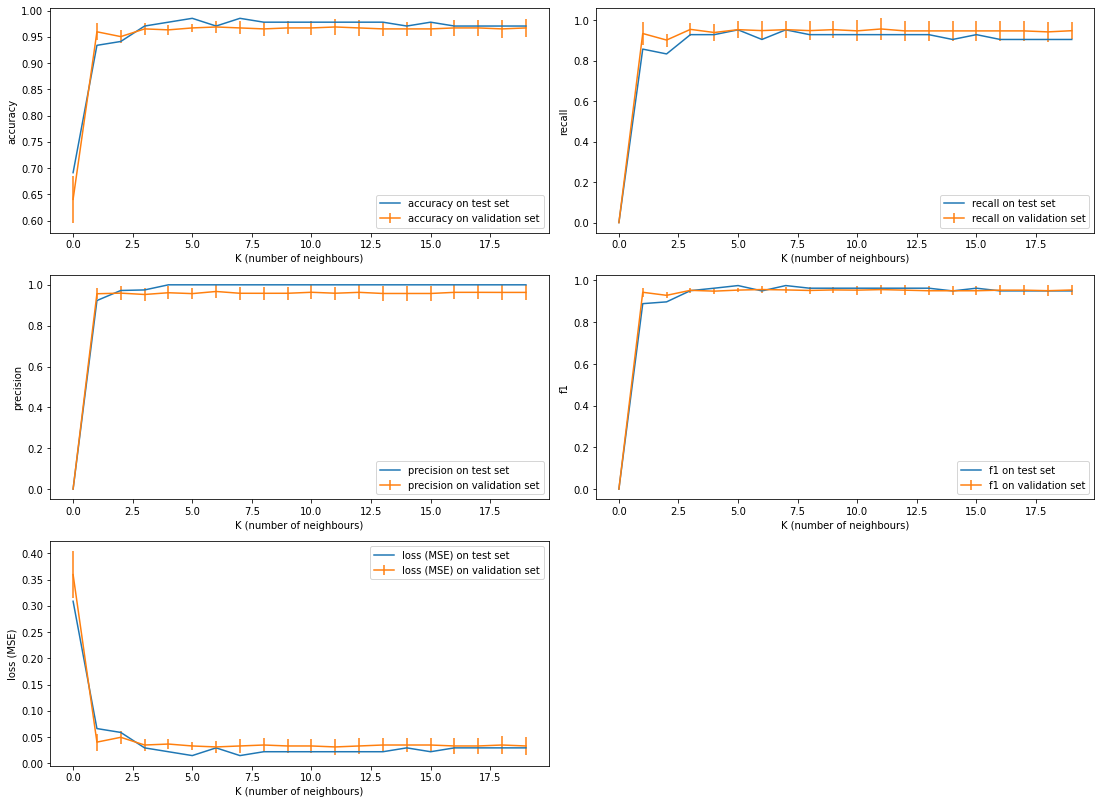

In [ ]:
metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t  = cross_validate_and_test(cancer_unscaled, K_range=20)
show_results(metrics, K_range=20)

results = results.append(pd.DataFrame({'Dataset':['cancer non-scaled'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

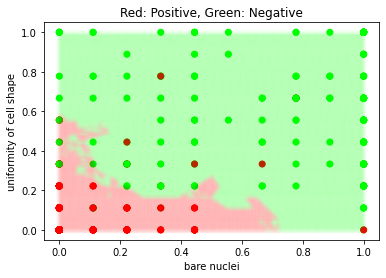

In [ ]:
display_decision_boundry(cancer_unscaled, 6, "bare nuclei","uniformity of cell shape","Decision boundry for cancer")

### 2.3 Scaled Breast Cancer Dataset with Manhattan Distance



In [ ]:
cancer_scaled = pd.read_csv(path+'cancer_scaled.csv', index_col=0)
cancer_scaled = cancer_scaled.to_numpy().astype(float)
np.random.shuffle(cancer_scaled)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 97.615 on validation set is obtained for K = 3 

Highest accuracy of 97.059 on test set is obtained for K = 3 


<Figure size 432x288 with 0 Axes>

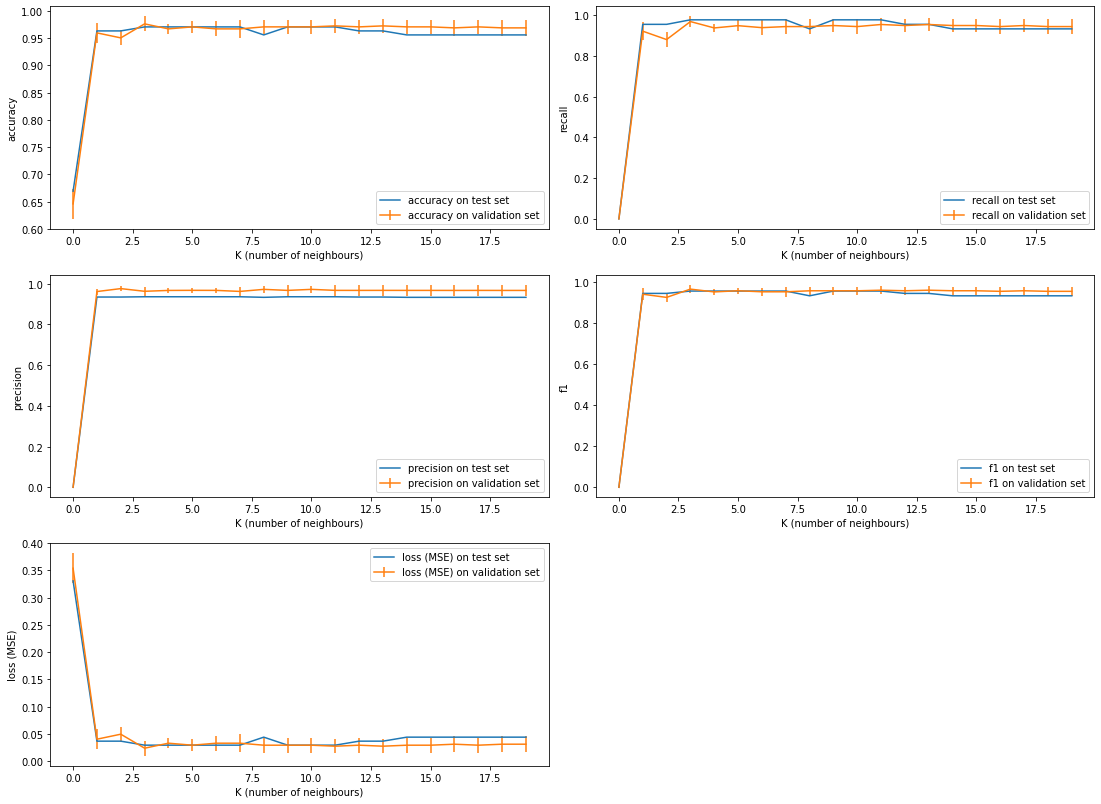

In [ ]:
metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t  = cross_validate_and_test(cancer_scaled, K_range=20, distance = manhattan)
show_results(metrics, K_range=20)

results = results.append(pd.DataFrame({'Dataset':['cancer scaled'], 'Distance':['Manhattan'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))



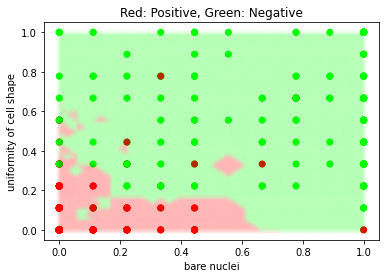

In [ ]:
display_decision_boundry(cancer_unscaled, 3, "bare nuclei","uniformity of cell shape",
                         "Decision boundry for cancer", distance = manhattan)

### 2.4 Non-Scaled Breast Cancer Dataset with Manhattan Distance



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 97.064 on validation set is obtained for K = 3 

Highest accuracy of 98.529 on test set is obtained for K = 3 


<Figure size 432x288 with 0 Axes>

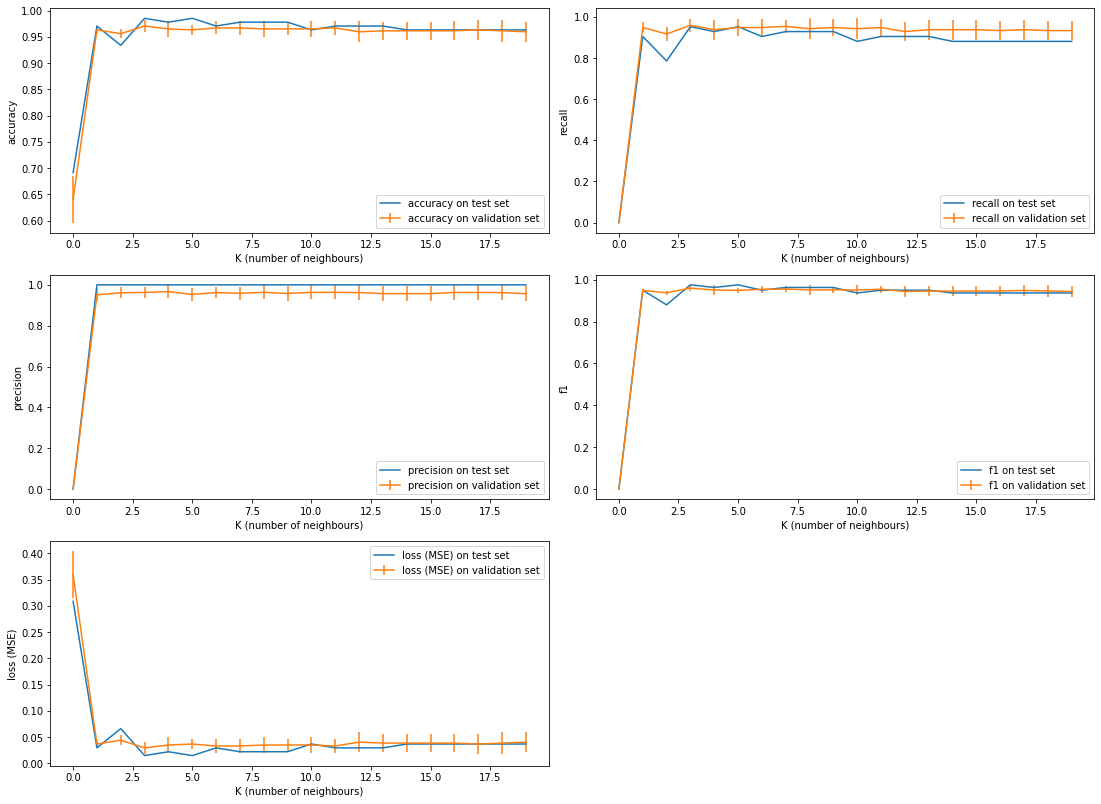

In [ ]:
metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t  = cross_validate_and_test(cancer_unscaled, K_range=20, distance = manhattan)
show_results(metrics, K_range=20)

results = results.append(pd.DataFrame({'Dataset':['cancer non-scaled'], 'Distance':['Manhattan'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))


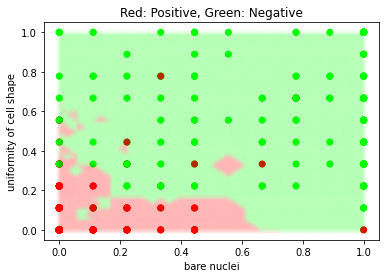

In [ ]:
display_decision_boundry(cancer_unscaled, 3, "bare nuclei","uniformity of cell shape",
                "Decision boundry for cancer", distance = manhattan)

###2.5 Results 

In [ ]:
results

,Dataset,Distance,Highest Accuracy (Val),Highest Accuracy (Test),Best K (Val),Best K (Test)
0,cancer scaled,Euclidean,0.970642,0.970588,5.0,5.0
1,cancer non-scaled,Euclidean,0.968807,0.985294,6.0,5.0
2,cancer non-scaled,Manhattan,0.970642,0.985294,3.0,3.0
3,cancer scaled,Manhattan,0.976147,0.970588,3.0,3.0


## 3 Binary Classification on Hepatitis Datasets Using KNN
Let's now test the algorithm on the  hepatitis datasets. We'll partition the dataset into a test set (20% of data) and a 5-fold cross validation set (80% of data). 

The cross validation set will be used to tune the hyperparameter K to minimize the generalization error. This error will be estimated using the mean squared error. 
We'll validate and test through K = 1 to K = 20, for various preprocessed datasets. 

In [210]:
#dataframe to contain our test results
results_h = pd.DataFrame({'Dataset':[], 'Distance':[], 'Highest Accuracy (Val)':[],
           'Highest Accuracy (Test)':[], 'Best K (Val)':[], 'Best K (Test)':[]})

### 3.1 Larger and Scaled Hepatitis Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 84.000 on validation set is obtained for K = 4 

Highest accuracy of 96.000 on test set is obtained for K = 15 


<Figure size 432x288 with 0 Axes>

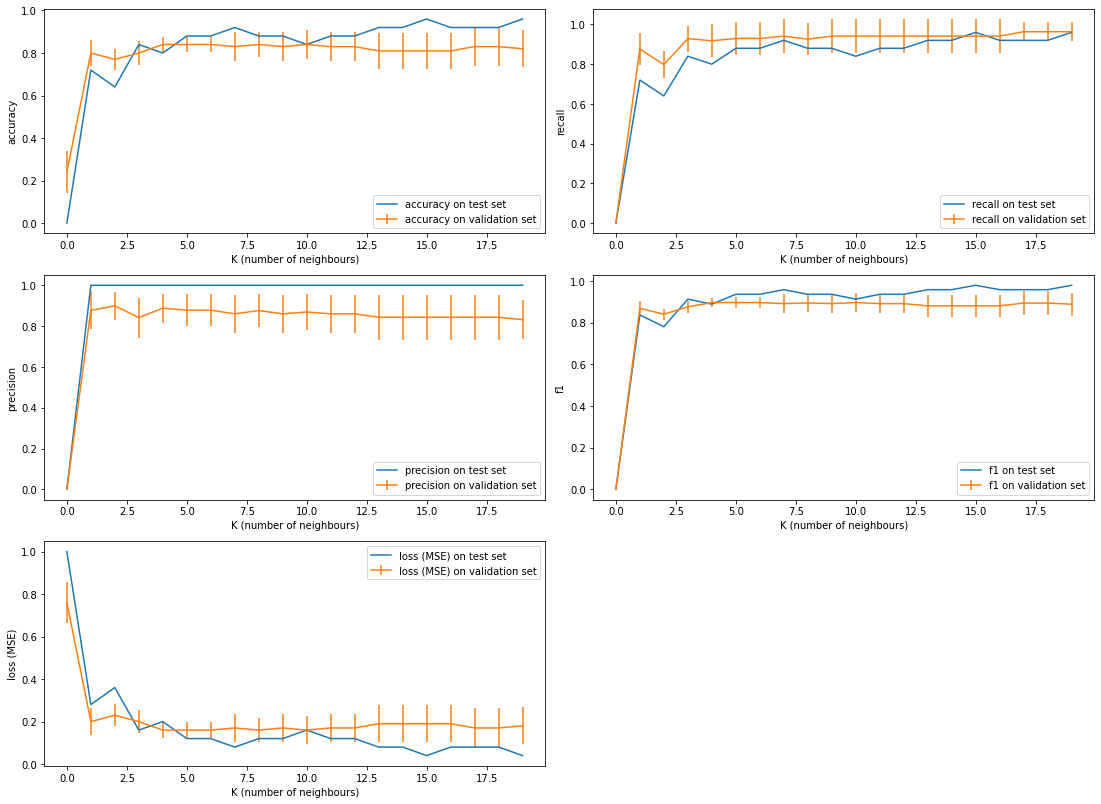

In [211]:
hep_large_scaled = pd.read_csv(path+'hep_large_scaled.csv', index_col=0)
hep_large_scaled = hep_large_scaled.to_numpy().astype(float)
np.random.shuffle(hep_large_scaled)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_large_scaled,K_range=20)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Large Scaled Hepatitis'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

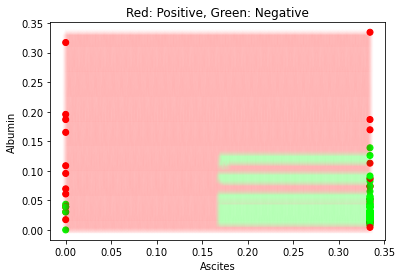

In [212]:
display_decision_boundry(hep_large_scaled, 4, "Ascites","Albumin"," ")

###3.2 Small and Scaled Hepatitis Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 93.333 on validation set is obtained for K = 6 

Highest accuracy of 93.750 on test set is obtained for K = 19 


<Figure size 432x288 with 0 Axes>

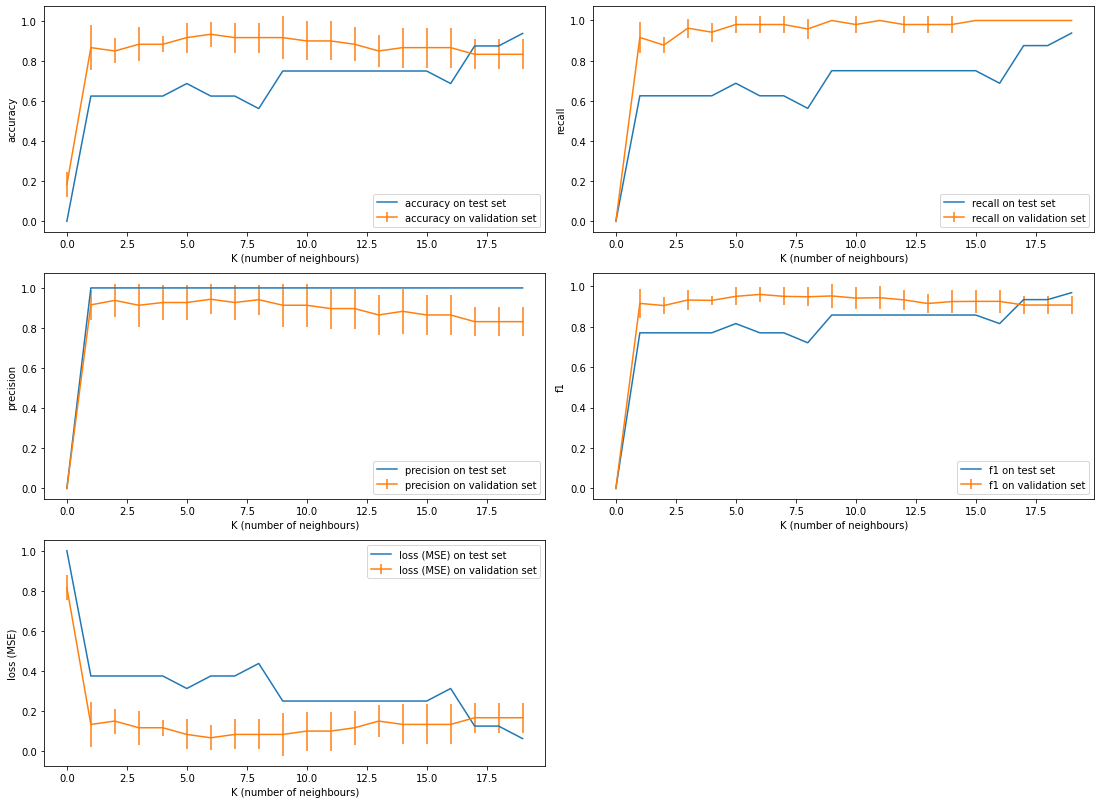

In [213]:
hep_small_scaled = pd.read_csv(path+'hep_small_scaled.csv', index_col=0)
hep_small_scaled = hep_small_scaled.to_numpy().astype(float)
np.random.shuffle(hep_small_scaled)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_small_scaled,K_range=20)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Small Scaled Hepatitis'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

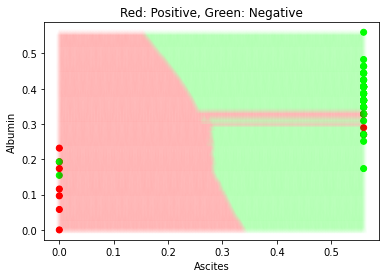

In [214]:
display_decision_boundry(hep_small_scaled, 6, "Ascites","Albumin"," ")


###3.3 Small and Non-Scaled Hepatitis Dataset

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 88.333 on validation set is obtained for K = 9 

Highest accuracy of 93.750 on test set is obtained for K = 1 


<Figure size 432x288 with 0 Axes>

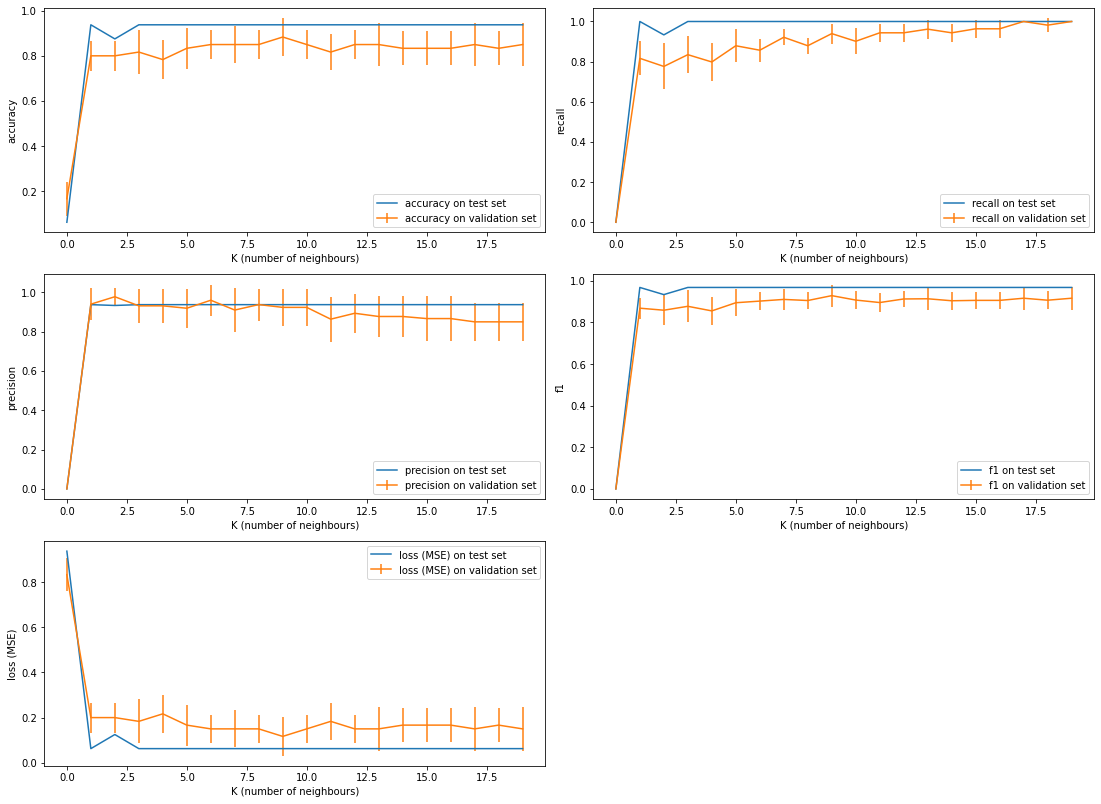

In [215]:
hep_small_unscaled = pd.read_csv(path+'hep_small_unscaled.csv', index_col=0)
hep_small_unscaled = hep_small_unscaled.to_numpy().astype(float)
np.random.shuffle(hep_small_unscaled)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_small_unscaled,K_range=20)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Small Non-Scaled Hepatitis'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

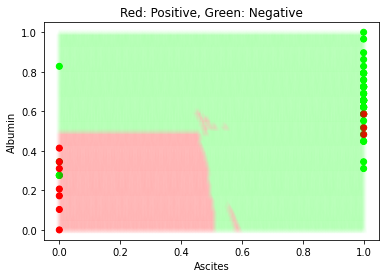

In [216]:
display_decision_boundry(hep_small_unscaled, 9, "Ascites","Albumin"," ")

###3.4 Large and Non-Scaled Hepatitis Dataset



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 87.000 on validation set is obtained for K = 7 

Highest accuracy of 84.000 on test set is obtained for K = 8 


<Figure size 432x288 with 0 Axes>

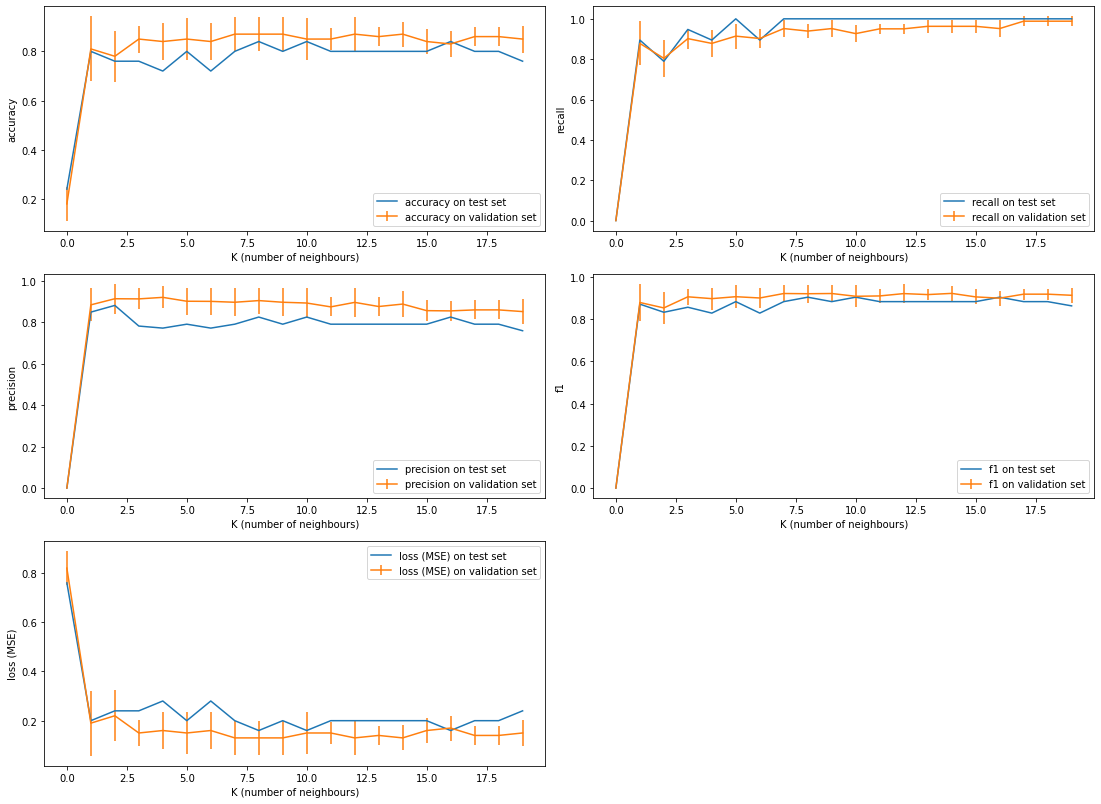

In [217]:
hep_large_unscaled = pd.read_csv(path+'hep_large_unscaled.csv', index_col=0)
hep_large_unscaled = hep_large_unscaled.to_numpy().astype(float)
np.random.shuffle(hep_large_unscaled)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_large_unscaled,K_range=20)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Large Non-Scaled Hepatitis'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

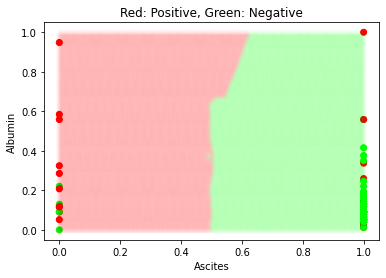

In [218]:
display_decision_boundry(hep_large_unscaled, 7, "Ascites","Albumin"," ")


### 3.5 Small and Scaled Hepatitis Dataset with Features Removed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 91.667 on validation set is obtained for K = 9 

Highest accuracy of 87.500 on test set is obtained for K = 17 


<Figure size 432x288 with 0 Axes>

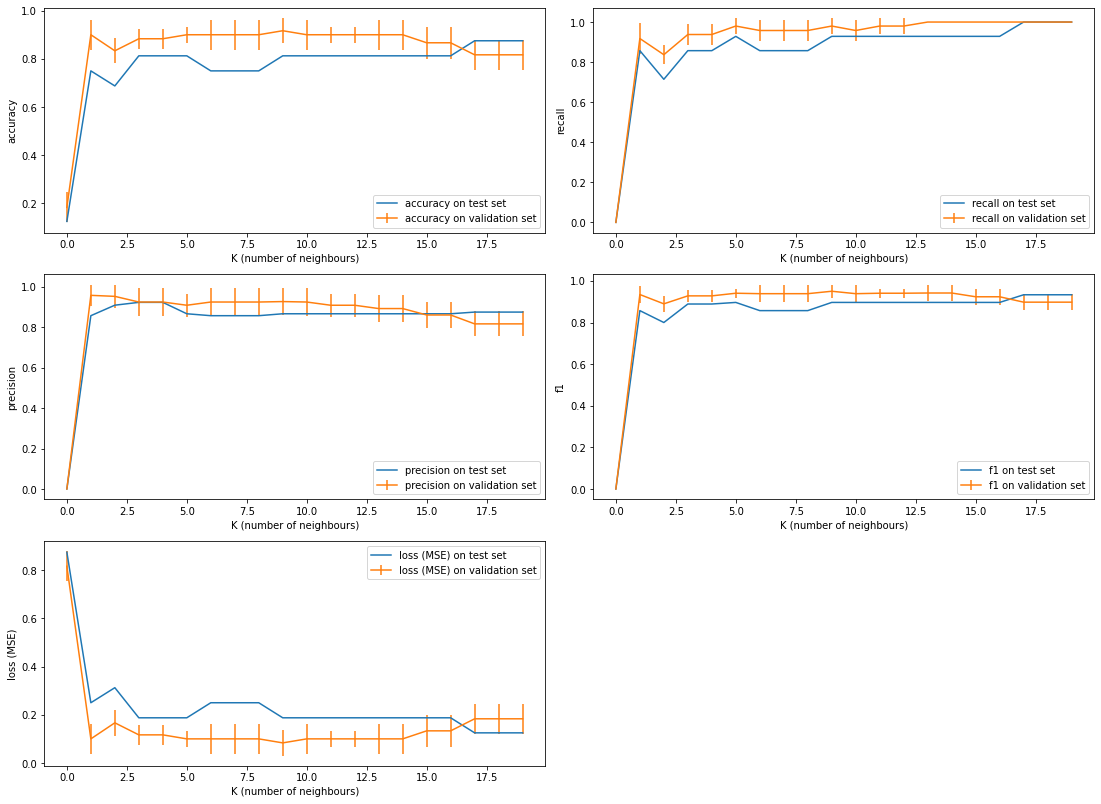

In [219]:
hep_small_scaled_removed = pd.read_csv(path+'hep_small_scaled_removed.csv', index_col=0)
hep_small_scaled_removed = hep_small_scaled_removed.to_numpy().astype(float)
np.random.shuffle(hep_small_scaled_removed)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_small_scaled_removed,K_range=20)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Small Scaled Hepatitis (features removed)'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))


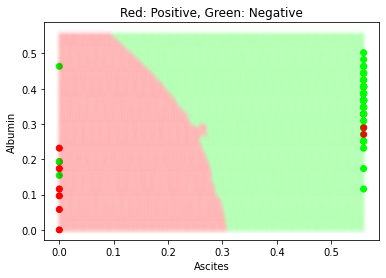

In [220]:
display_decision_boundry(hep_small_scaled_removed,9, "Ascites","Albumin"," ")


### 3.6 Large and Scaled Hepatitis Dataset with Features Removed

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 83.000 on validation set is obtained for K = 13 

Highest accuracy of 100.000 on test set is obtained for K = 3 


<Figure size 432x288 with 0 Axes>

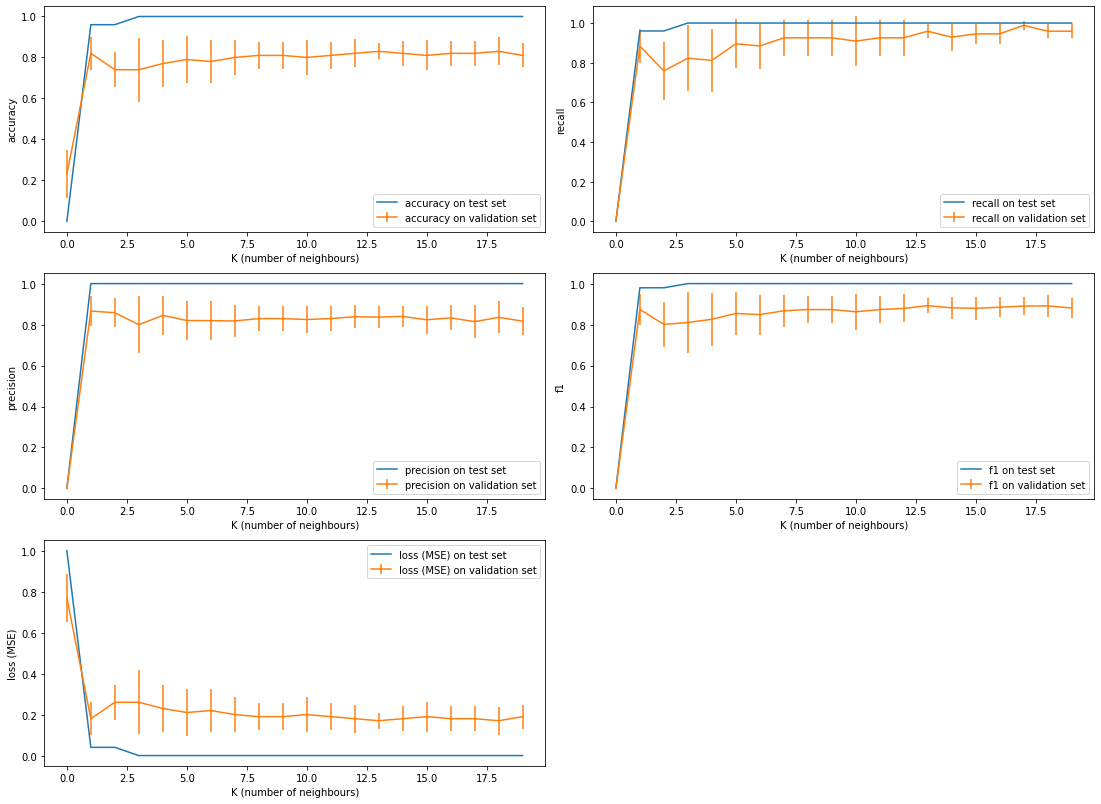

In [221]:
hep_large_scaled_removed = pd.read_csv(path+'hep_large_scaled_removed.csv', index_col=0)
hep_large_scaled_removed = hep_large_scaled_removed.to_numpy().astype(float)
np.random.shuffle(hep_small_scaled_removed)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_large_scaled_removed,K_range=20)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Large Scaled Hepatitis (features removed)'], 'Distance':['Euclidean'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))


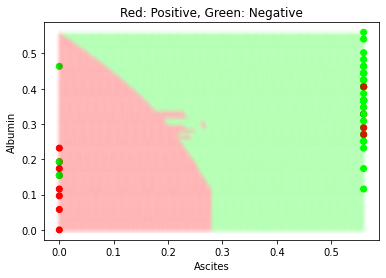

In [222]:
display_decision_boundry(hep_small_scaled_removed,13, "Ascites","Albumin"," ")


### 3.7 Small and Scaled Hepatitis Dataset Using Manhattan Distance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 88.333 on validation set is obtained for K = 3 

Highest accuracy of 87.500 on test set is obtained for K = 3 


<Figure size 432x288 with 0 Axes>

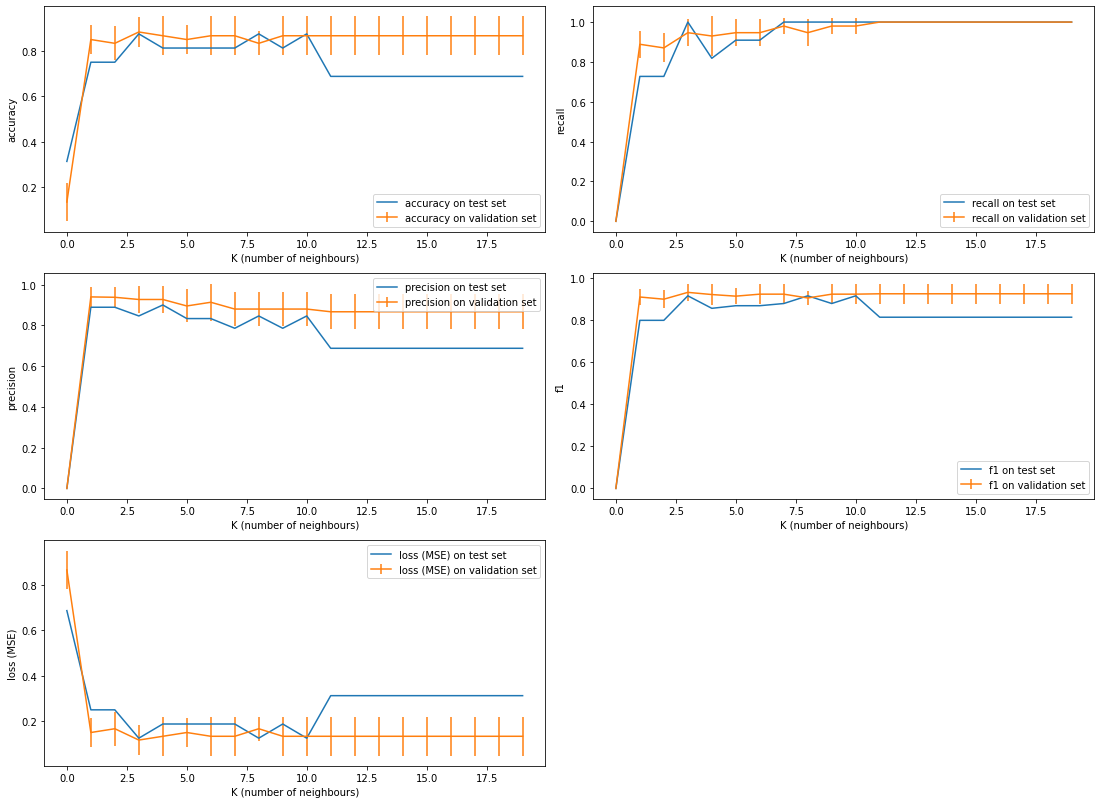

In [226]:
hep_small_scaled = pd.read_csv(path+'hep_small_scaled.csv', index_col=0)
hep_small_scaled = hep_small_scaled.to_numpy().astype(float)
np.random.shuffle(hep_small_scaled)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_small_scaled,K_range=20, distance = manhattan)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Small Scaled Hepatitis'], 'Distance':['Manhattan'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

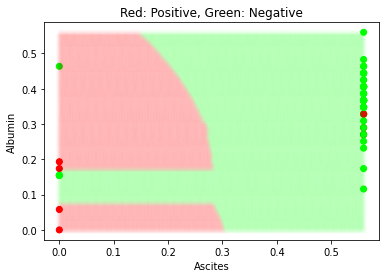

In [227]:
display_decision_boundry(hep_small_scaled,3, "Ascites","Albumin"," ")


### 3.8 Large and Scaled Hepatitis Dataset Using Manhattan Distance

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Highest accuracy of 84.000 on validation set is obtained for K = 11 

Highest accuracy of 100.000 on test set is obtained for K = 3 


<Figure size 432x288 with 0 Axes>

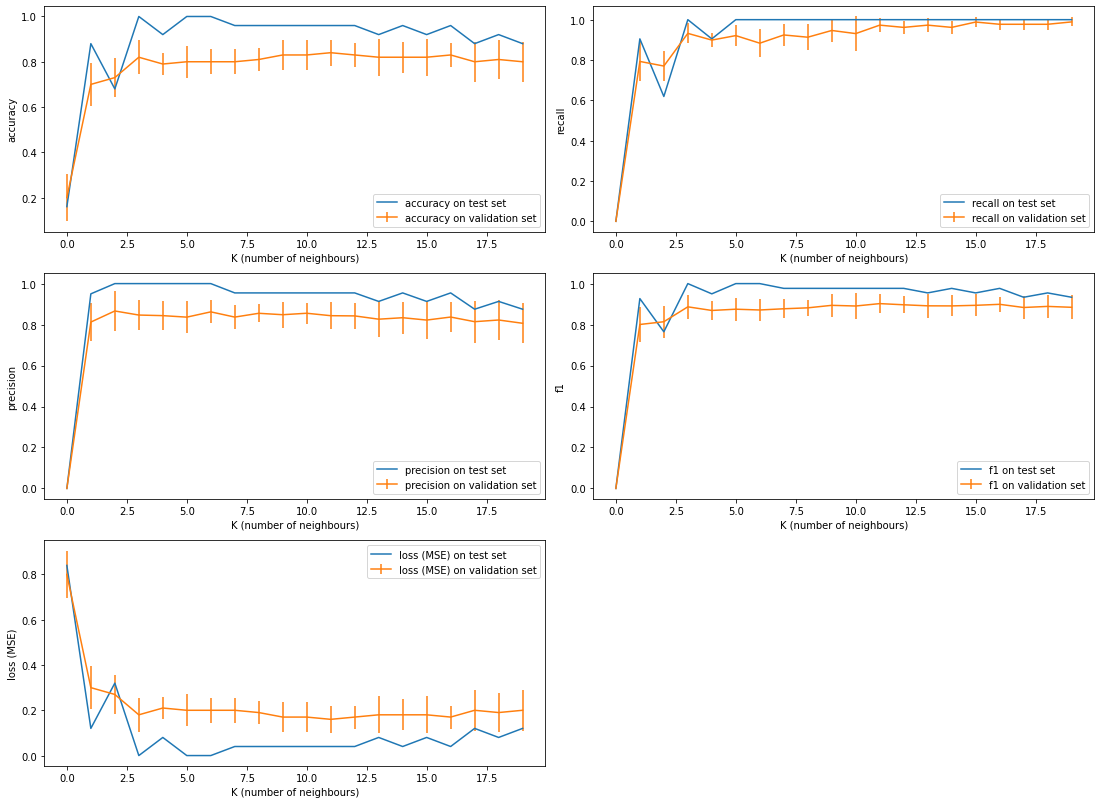

In [228]:
hep_large_scaled = pd.read_csv(path+'hep_large_scaled.csv', index_col=0)
hep_large_scaled = hep_large_scaled.to_numpy().astype(float)
np.random.shuffle(hep_large_scaled)

metrics, best_accuracy_v, best_accuracy_t, best_K_v, best_K_t = cross_validate_and_test(hep_large_scaled,K_range=20, distance = manhattan)
show_results(metrics, K_range=20)

results_h = results_h.append(pd.DataFrame({'Dataset':['Large Scaled Hepatitis'], 'Distance':['Manhattan'],
                'Highest Accuracy (Val)':[best_accuracy_v],'Highest Accuracy (Test)':[best_accuracy_t],
                 'Best K (Val)':[best_K_v], 'Best K (Test)':[best_K_t]}))

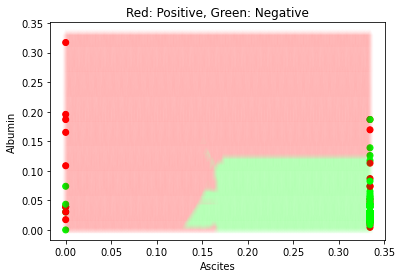

In [229]:
display_decision_boundry(hep_large_scaled,11, "Ascites","Albumin"," ")


###3.9 Results

In [235]:

results_h

,Dataset,Distance,Highest Accuracy (Val),Highest Accuracy (Test),Best K (Val),Best K (Test)
0,Large Scaled Hepatitis,Euclidean,0.840000,0.9600,4.0,15.0
1,Small Scaled Hepatitis,Euclidean,0.933333,0.9375,6.0,19.0
2,Small Non-Scaled Hepatitis,Euclidean,0.883333,0.9375,9.0,1.0
3,Large Non-Scaled Hepatitis,Euclidean,0.870000,0.8400,7.0,8.0
4,Small Scaled Hepatitis (features removed),Euclidean,0.916667,0.8750,9.0,17.0
5,Large Scaled Hepatitis (features removed),Euclidean,0.830000,1.0000,13.0,3.0
8,Small Scaled Hepatitis,Manhattan,0.883333,0.8750,3.0,3.0
9,Large Scaled Hepatitis,Manhattan,0.840000,1.0000,11.0,3.0
